In [11]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1 - Data loading and cleaning
We first load the csv file into a panda dataframe and drop every row with missing information (i.e. a null value)

In [12]:
data = pd.read_csv("nba_logreg.csv")
data = data.dropna()
data.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


#### Visualisation of the data and balancing
In this step we get the number of players classified in both categories. We realise that the data is already quite balanced and doesn't necessarily require balancing.

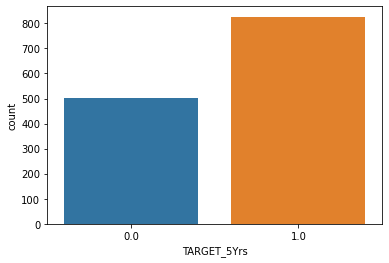

In [13]:
seaborn.countplot(x="TARGET_5Yrs", data=data)
plt.show()

#### Data insight
We group each row by category, intuitivly the mean stats of the player who play in the nba for more than 5 years in the nba are higher

Rookie ending up playing more than 5 years play more, score more, get more rebounds, assists.

#### Counter-intuitive observations
- 3P% : We notice that rookies classified as 1 have a slightly worst 3 points percentage on average but a bigger 3 points attempts number. Which means that rookies ending up being successful in the nba seems to attemps more 3 points even though it doesn't always pay up.

- TOV : Also the number of turn-overs is higher for rookies classified as 1, which means they lose the ball more. This is likely correlated with the fact that they play more in average and then get more chance to lose the ball during the match.

In [14]:
data.groupby('TARGET_5Yrs').mean()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
TARGET_5Yrs,,,,,,,,,,,,,,,,,,,
0.0,51.495030,14.276740,5.060636,1.951093,4.562425,42.270775,0.232406,0.763618,19.378131,0.928231,1.324254,69.122266,0.713519,1.522863,2.234592,1.230815,0.500000,0.249901,0.944732
1.0,65.826877,19.700847,7.891646,3.051090,6.718523,45.242131,0.260169,0.799031,19.265496,1.530872,2.133656,71.189588,1.186683,2.325061,3.511864,1.758838,0.693705,0.436925,1.349031


#### Determining good predictors
We draw a distribution graph for every variable and compare the distribution for players classified as 0 and the ones classified as 1.
We then redraw each graph which seems to indicate a good predictor.

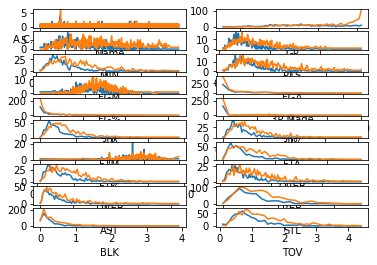

In [15]:
plot_per_line = 2

nbr_rows = len(data.columns) // plot_per_line

for i in range(len(data.columns) - 1):
    ax = plt.subplot(nbr_rows, plot_per_line, (i + 1))
    pd.crosstab(data[data.columns[i]], data.TARGET_5Yrs).plot(ax=ax, legend=None)

plt.show()

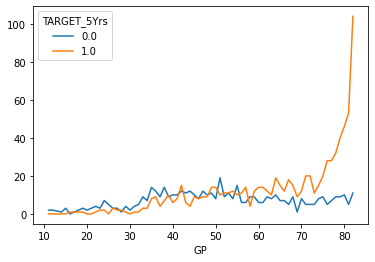

In [16]:
pd.crosstab(data.GP, data.TARGET_5Yrs).plot()
plt.show()

The number of game played seems to be a good predictor when the number of game played is more than 75

#### More data cleaning and normalizing
We remove the name column which is meaningless for our model, we also normalize the data using the sklearn library. Finally we split our data into training and test data.

In [26]:
from sklearn import preprocessing

# Select the data
X = data.loc[:, data.columns != "TARGET_5Yrs"]

# Select the labels
y = data.loc[:, "TARGET_5Yrs"]

# Remove the name column
X = X.loc[:, X.columns != "Name"]

# Normalize the data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

print(X_train.shape)
print(X_test.shape)

(1129, 19)
(200, 19)


#### Meaningful features selection
First we use the statsmodels library to perform logistic regression from a statistic point of view. This library will compute p-values for us and determine which feature are considered significant.

In [27]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
print(type(y_train))
logit_model = sm.Logit(np.asarray(y_train), X_train)
result = logit_model.fit()
print(result.summary2())

<class 'pandas.core.series.Series'>
Optimization terminated successfully.
         Current function value: 0.590316
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.117     
Dependent Variable: y                AIC:              1370.9346 
Date:               2022-01-01 17:18 BIC:              1466.4873 
No. Observations:   1129             Log-Likelihood:   -666.47   
Df Model:           18               LL-Null:          -754.43   
Df Residuals:       1110             LLR p-value:      6.1526e-28
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.5957     0.0887    6.7143   0.0000    0.4218    0.7696
x2        -0.2756     

#### Interpretation of p-values

p-values above 0.05 are not considered statistically significant, hence we can remove the following features x2: MIN, x3: PTS, x4: FGM, x9: 3P%, x10: FTM, x11: FTA, x12: FT%, x13: OREB, x14: DREB, x15: REB, x17: STL, x19: TOV


We can also notice that our insight that the feature GP (number of Games Played) will make a good predictor was right. As a matter of fact its p-value is 0.00000. Also the 3P% and TOV are bad predictors as expected (with p-value higher 0.05 hence not statistically significant).

In [78]:
# we only select features x1, x5, x6, x7, x8, x16, x18 (columns 0, 4, 5, 6, 7, 15, 17)
X_reduced = X_scaled[:, [0, 4, 5, 6, 7, 15, 17]]

# Split data into training and test data with the new data
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.15, random_state=42)

## 2 - Model fitting
Now that the data is cleaned, and only meaningful features are selected, we can run the logistic regression algorithm with the sklearn.

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

print(logreg.score(X_test, y_test))

0.74


## 3 - Model evaluation
We compute the confusion matrix, precision, recall and f1-score.

In [80]:
from sklearn.metrics import confusion_matrix

y_pred = logreg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 36  28]
 [ 24 112]]


In [81]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58        64
         1.0       0.80      0.82      0.81       136

    accuracy                           0.74       200
   macro avg       0.70      0.69      0.70       200
weighted avg       0.74      0.74      0.74       200



#### Interpretation of precision and recall for our model

Precision and recall is way higher for class 1, which means our model is better for classifying players that will be successful in the NBA, i.e. it will most likely classify most of the successful players as 1 and not wrongly classify unsuccessful players as 1.

On the other hand precision and recall is lower for class 0, which means our model might not classify all the unsuccessful players as 0 and players classified as 0 might still be successful.